# Classifying text using a Naive Bayes classifier

## Loading the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
import os

data_dir = f'{os.getcwd()}/data'

if not os.path.exists(data_dir):
  os.mkdir(data_dir)

In [3]:
import requests

url = (
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/'
    'sentiment%20labelled%20sentences.zip'
)

response = requests.get(url)

In [4]:
import zipfile
from io import BytesIO

with zipfile.ZipFile(file=BytesIO(response.content), mode='r') as file:
  file.extractall(data_dir)


In [5]:
df_list = []

for csv_file in ['amazon_cells_labelled.txt',
                 'imdb_labelled.txt',
                 'yelp_labelled.txt']:
                 csv_file_with_path = (
                     f'{data_dir}/sentiment labelled sentences/{csv_file}'
                 )
                 temp_df = pd.read_csv(
                     csv_file_with_path,
                     sep='\t',
                     header=0,
                     names=['text', 'sentiment']
                 )
                 df_list.append(temp_df)

df = pd.concat(df_list)

In [6]:
df.head()

,text,sentiment
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [7]:
df.shape

(2745, 2)

## Distribution of the sentiment labels

Negative (0) 1385
Positive (1) 1360


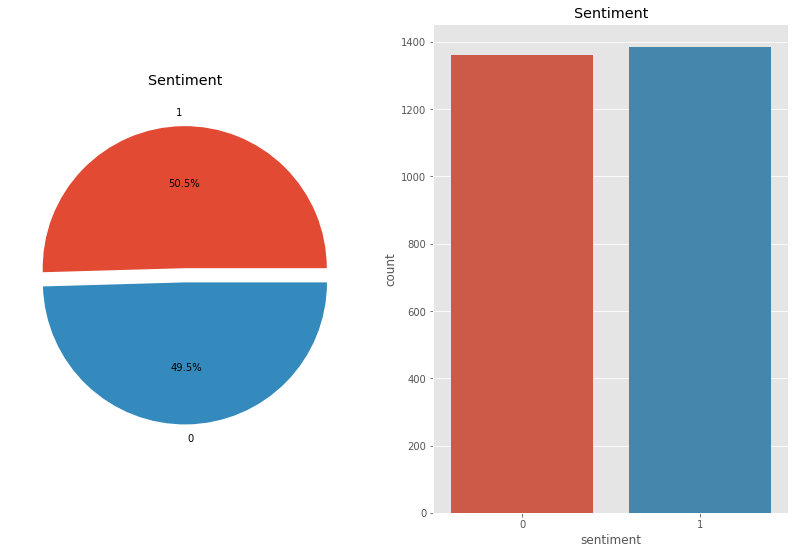

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 9))
df.sentiment.value_counts().plot.pie(
    explode=[0, 0.1], 
    autopct='%1.1f%%',
    ax=ax[0]
    )
ax[0].set_title('Sentiment')
ax[0].set_ylabel('')

sns.countplot('sentiment', data=df, ax=ax[1])
N, P = df.sentiment.value_counts()
ax[1].set_title('Sentiment')
print('Negative (0)', N)
print('Positive (1)', P)

In [9]:
df['sentiment'].value_counts() / df['sentiment'].shape[0]

1    0.504554
0    0.495446
Name: sentiment, dtype: float64

In [10]:
pd.options.display.max_colwidth = 90
df[['text', 'sentiment']].sample(5, random_state=42)

,text,sentiment
471,Disappointment.. I hate anything that goes in my ear.,0
26,It is a true classic.,1
767,Great product.,1
150,This is a great restaurant at the Mandalay Bay.,1
430,It finds my cell phone right away when I enter the car.,1


## Preparing the data

In [11]:
data, target = df[['text']], df.sentiment

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=.4,
    random_state=121,
    stratify=target,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1647, 1), (1647,), (1098, 1), (1098,))

In [13]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.504554
0    0.495446
Name: sentiment, dtype: float64
1    0.504554
0    0.495446
Name: sentiment, dtype: float64


## Textual features

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# n_grams
vec = CountVectorizer(ngram_range=(1,3), min_df=3, strip_accents='ascii')

x_train = vec.fit_transform(X_train['text'])
x_test = vec.transform(X_test['text'])

X_test.head()

,text
600,"The real killer is the volume, and of course it breaking."
788,I can't use this case because the smell is disgusting.
549,"I'm a big fan of this series mostly due to Anne Rice's style, sensitivities and treatm..."
659,"I personally love the hummus, pita, baklava, falafels and Baba Ganoush (it's amazing w..."
190,Any ring tone..Overall good phone to buy..


In [15]:
pd.DataFrame(x_train.todense(), columns=vec.get_feature_names_out()).head(10)

,10,20,30,30 minutes,40,50,510,90,ability,about,...,you need,you pay,you re,you want,you won,your,your money,your time,yourself,yummy
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## NB Model

In [16]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=True)
clf.fit(x_train, y_train)

MultinomialNB()

In [17]:
y_pred = clf.predict(x_test)

Out of the samples that were assigned to the positive class, the percentage of them that were actually positive is the precision of this class. For the positive tweets, the percentage of them that the classifier correctly predicted to be positive is the recall for this class. As you can see, the precision and recall are calculated per class.

In [18]:
from sklearn.metrics import precision_recall_fscore_support 

p, r, f, s = precision_recall_fscore_support(y_test, y_pred)

In [19]:
pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
).round(2)

,Precision,Recall,F,Support
0,0.79,0.81,0.8,544
1,0.81,0.79,0.8,554


In [20]:
pd.Series(p).round(2)

0    0.79
1    0.81
dtype: float64

In [21]:
pd.Series(p).round(4).mean()

0.79705

In [22]:
y_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 79.70% & Recall=79.70%


In [23]:
precision_recall_fscore_support(y_test, y_pred, average='micro')[2]

0.796903460837887

## Pipeline

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV


pipe = Pipeline(steps=[
 ('CountVectorizer', CountVectorizer()),
 ('MultinomialNB', MultinomialNB())]
)

In [25]:
param_grid = {
 'CountVectorizer__ngram_range': [(1,1), (1,2), (1,3)],
 'MultinomialNB__alpha': [0.1, 1],
 'MultinomialNB__fit_prior': [True, False],
}

search = GridSearchCV(pipe,
                      param_grid=param_grid,
                      scoring='precision_macro',
                      n_jobs=-1)

search.fit(X_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 1), 'MultinomialNB__alpha': 1, 'MultinomialNB__fit_prior': False}


In [26]:
vec = CountVectorizer(ngram_range=(1,2), min_df=3, strip_accents='ascii')

x_train = vec.fit_transform(X_train['text'])
x_test = vec.transform(X_test['text'])

clf = MultinomialNB(fit_prior=False, alpha=1)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 80.07% & Recall=80.06%


# Creating a custom transformer

In [27]:
!python -m spacy download en_core_web_lg --quiet

     |████████████████████████████████| 827.9 MB 1.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [30]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [31]:

# pip install tqdm
from tqdm import tqdm
tqdm.pandas()

In [32]:
import spacy

class WordEmbeddingVectorizer:
    
    def __init__(self, language_model='en_core_web_lg'):
        self.nlp = spacy.load(language_model)
    
    def fit(self):
        pass
    
    def transform(self, x, y=None):
        return pd.Series(x).progress_apply(
            lambda doc: self.nlp(doc).vector.tolist()
        ).values.tolist()
    
    def fit_transform(self, x, y=None):
        return self.transform(x)
    

vec = WordEmbeddingVectorizer()
x_train_w2v = vec.transform(X_train['text'])
x_test_w2v = vec.transform(X_test['text'])

100%|██████████| 1098/1098 [00:12<00:00, 87.17it/s]


In [34]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
# clf = SGDClassifier(loss='log', max_iter=10000, class_weight='balanced')
clf = LogisticRegression(max_iter=10000, class_weight=None)

x_train_scaled = scaler.fit_transform(x_train_w2v)
x_test_scaled = scaler.transform(x_test_w2v)

clf.fit(x_train_scaled, y_train)
y_test_pred = clf.predict(x_test_scaled)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index=[0,1] 
)

,Precision,Recall,F,Support
0,0.805505,0.806985,0.806244,544
1,0.810127,0.808664,0.809395,554


In [35]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.807832422586521